In [44]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import optimizers
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.models import Sequential
from keras import backend as K

print(os.listdir("data"))

['test_simplified.csv', 'train_simplified.zip', 'train_simplified']


In [2]:
TRAIN_PATH = "data/train_simplified/"
TEST_PATH = "data/test_simplified.csv"
SUBMISSION_NAME = 'submission.csv'

In [97]:
train = pd.DataFrame()

for file in os.listdir(TRAIN_PATH):
    train = train.append(pd.read_csv(TRAIN_PATH + file, usecols = [1, 5], nrows = 200))
train = shuffle(train, random_state=123)  

In [98]:
len(train)

68000

In [99]:
# fixing label in the training set
train['word'] = train['word'].replace(' ', '_', regex=True)

# get labels and one-hot encode them.
n_classes = train['word'].unique()
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)

print("Total number of labels: "+str(len(labels)))

Total number of labels: 68000


In [70]:
print(labels[1000])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [103]:
BASE_SIZE = 256
RE_SIZE = (70,70)

def datapoints_to_img(raw_strokes, size=256, lw=6, time_color=True):
    
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    return cv2.resize(img, RE_SIZE, interpolation=cv2.INTER_AREA)

In [104]:
#  training datapoints stacked in a list
drawings_train = [ast.literal_eval(pts) for pts in train['drawing'].values]
print(len(drawings_train))

68000


In [73]:
training_images = []
i = 0
for stroke in drawings_train:
    img = datapoints_to_img(stroke)
    training_images.append(img)
    print('processed {}/{}'.format(i+1,len(drawings_train)),end = '\r', flush=True)
    i+=1

In [74]:
training_images = np.array(training_images)

In [75]:
len(training_images)

68000

In [76]:
print(training_images.shape)

(68000, 70, 70)


In [77]:
np.save('training_images',training_images)
np.save('labels',labels)

In [105]:
x_train, x_val, y_train, y_val = train_test_split(training_images, labels, test_size=0.1, random_state=1)

In [106]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((61200, 70, 70), (61200, 340), (6800, 70, 70), (6800, 340))

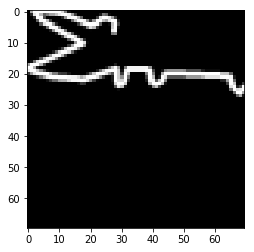

In [107]:
this = 500
plt.imshow(x_train[this], cmap='gray')

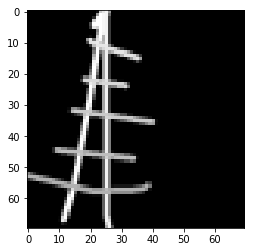

In [108]:
this = 1200
plt.imshow(x_val[this], cmap='gray')

In [109]:
img_rows = 70
img_cols = 70

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(input_shape)

(70, 70, 1)


In [110]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

In [111]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((61200, 70, 70, 1), (61200, 340), (6800, 70, 70, 1), (6800, 340))

In [112]:
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)

print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

x_train shape: (61200, 70, 70, 1)
x_val shape: (6800, 70, 70, 1)
61200 train samples
6800 test samples


In [113]:
# now feed it to the model

In [114]:
def get_model():
    
    input_layer=Input(shape=input_shape)
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=340)(x) 
    output_layer=Activation('softmax')(x)
    
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    
    return model

model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 70, 70, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 66, 66, 8)         208       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 31, 31, 16)        1168      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 32)          0         
__________

In [115]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(61200, 70, 70, 1) (61200, 340) (6800, 70, 70, 1) (6800, 340)


In [95]:
#https://github.com/tajwarabraraleef/kaggle-quickdraw/blob/master/temp/read.py

In [116]:
path_model='google_quickdraw.h5' 
model=get_model() 
K.set_value(model.optimizer.lr,1e-3) # set the learning rate

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64,
            epochs=20,
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 61200 samples, validate on 6800 samples
Epoch 1/20
61200/61200 [==============================] - 204s 3ms/step - loss: 4.4613 - acc: 0.1318 - val_loss: 3.5825 - val_acc: 0.2424
Epoch 2/20
61200/61200 [==============================] - 200s 3ms/step - loss: 3.2389 - acc: 0.3004 - val_loss: 3.0867 - val_acc: 0.3234
Epoch 3/20
61200/61200 [==============================] - 203s 3ms/step - loss: 2.8580 - acc: 0.3645 - val_loss: 2.8666 - val_acc: 0.3640
Epoch 4/20
61200/61200 [==============================] - 225s 4ms/step - loss: 2.6418 - acc: 0.4028 - val_loss: 2.7694 - val_acc: 0.3816
Epoch 5/20
61200/61200 [==============================] - 210s 3ms/step - loss: 2.4817 - acc: 0.4337 - val_loss: 2.7008 - val_acc: 0.3929
Epoch 6/20
61200/61200 [==============================] - 217s 4ms/step - loss: 2.3649 - acc: 0.4538 - val_loss: 2.6472 - val_acc: 0.4051
Epoch 7/20
61200/61200 [==============================] - 216s 4ms/step - loss: 2.2729 - acc: 0.4719 - val_loss: 2.6331 - v

In [118]:
test = pd.read_csv(TEST_PATH, usecols=[0, 2], nrows=None) # was 100 before
print(len(test))

112199


In [119]:
#  testing datapoints stacked in a list
drawings_test = [ast.literal_eval(pts) for pts in test['drawing'].values]
len(drawings_test)

112199

In [133]:
testing_images = []
i = 0
for stroke in drawings_test:
    img = datapoints_to_img(stroke)
    testing_images.append(img)
    print('processed {}/{}'.format(i+1,len(drawings_test)),end = '\r', flush=True)
    i+=1

In [134]:
len(testing_images)

112199

In [135]:
testing_images = np.array(testing_images)

In [136]:
np.save('testing_images',testing_images)

In [137]:
if K.image_data_format() == 'channels_first':
    testing_images = testing_images.reshape(testing_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    testing_images = testing_images.reshape(testing_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [138]:
testing_images = testing_images.astype('float32')

In [139]:
testing_images.shape

(112199, 70, 70, 1)

In [140]:
predictions = model.predict(testing_images)

In [146]:
print(len(predictions))

112199


In [147]:
x = np.argpartition(predictions[5], -3)[-3:]
print(x)

[113 282 324]


In [150]:
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (n_classes[pred[0]], n_classes[pred[1]], n_classes[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions

In [151]:
len(top_3_predictions)

112199

In [153]:
print(top_3_predictions[101000])

streetlight hedgehog rake


In [154]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head()

,key_id,word
0,9000003627287624,streetlight bench knee
1,9000010688666847,streetlight bench basketball
2,9000023642890129,bench ice_cream church
3,9000038588854897,streetlight wine_bottle van
4,9000052667981386,line bench asparagus
